# Linear and univariate observational constraint
The linear observational constrain is applied in the notebook "Part3_observational_constrain.ipynb".

The aim is to constrain the distribution of a given variable $Y$. To do so, we use an ensemble of $M$ climate models, that gives: $(X_1, Y_1), ..., (X_M,Y_M)$.

As described in the article, the unconstrained confidence interval is:
$$ [\hat{\mu}_Y \pm \, t^{M-1} \, \hat{\sigma}_Y\, \sqrt{1+\frac{1}{M}}]  $$

With $\hat{\mu}_Y$ the estimator of $Y$ expectation, $\hat{\sigma}_Y^2$ the estimator of $Y$ variance, and $t^{M-1}$ the quantile of a Student with $M-1$ degrees of freedom.


The confidence interval constrained by a noisy observation is:
$$ [\hat{b}_0 + \hat{b}_1 x_0^N \pm t^{M-2} \, \hat{\sigma}_{\varepsilon^N} \sqrt{1 + \frac{1}{M} + \cfrac{(x_0^N-\hat{\mu}_X)^2}{M\, (\hat{\sigma}_X^2  + \sigma_N^2)}}] $$


With:
- $\hat{b}_1 = \hat{Cov}(Y,X) / (\hat{\sigma}_X^2 + \sigma_N^2)$, the slope
- $\hat{b}_0 = \hat{\mu}_Y - \hat{b}_1 \hat{\mu}_X$, the intercept
- $\hat{\sigma}_{\varepsilon^N}^2 = \frac{1}{M-1} \sum_{i=1}^M (Y_i - \hat{b}_0 - \hat{b}_1 x_i)^2 + \hat{b}_1^2 \sigma_N^2 $, the error
- $x_0^N$ the noisy observation

The observational noise variance, is estimated as the variance on the HadCRUT5 ensemble.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import t


# Import data

In [2]:
min_X = np.datetime64('2015') # 1851
max_X = np.datetime64('2023') # 2014
min_Y = np.datetime64('2091')
max_Y = np.datetime64('2100')

X_mod   = np.load("../data/X_mod.npy")-273.15 # conversion from K to °C
Y_mod   = np.load("../data/Y_mod.npy")-273.15 # conversion from K to °C
X_obs   = np.load("../data/X_obs.npy")
std_obs = np.load("../data/std_obs.npy")
list_runs = np.load("../data/list_runs.npy")
list_models = np.load("../data/list_models.npy")

# Constrained distribution vs unconstrained distribution

In [3]:
confidence = 0.68

mu_Y    = np.mean(Y_mod)
mu_X    = np.mean(X_mod)
cov_YX  = np.cov(Y_mod, X_mod)[0,1]
var_X   = np.var(X_mod)
var_Y   = np.var(Y_mod)
std_Y   = np.sqrt(var_Y)
var_obs = np.square(std_obs)

mu_X_given_X_obs  = mu_X + (var_X/(var_X+var_obs))*(X_obs-mu_X)
mu_Y_given_X_obs  = mu_Y + (cov_YX/(var_X+var_obs))*(X_obs - mu_X)
var_Y_given_X_obs = var_Y - (cov_YX/(var_X+var_obs))*cov_YX
std_Y_given_X_obs = np.sqrt(var_Y_given_X_obs)

x = np.linspace(X_mod.min(), X_mod.max())
M = len(Y_mod)
b1 = cov_YX/(var_X+var_obs)
b0 = mu_Y - b1*mu_X
std_err = np.sum((Y_mod-b0-b1*X_mod)**2)/(M-1) + b1**2 * var_obs


unconstrained_interval = mu_Y + np.array(t.interval(confidence, M-1)) * std_Y * np.sqrt(1+1/M)
constrained_interval = b0+b1*X_obs + np.array(t.interval(confidence, M-2)) * std_err * np.sqrt(1+1/M+((X_obs-mu_X)**2/(M*(var_X+var_obs))))
constrained_tube = np.array([b0+b1*x_ +
                    np.array(t.interval(confidence, M-2)) *
                    std_err * np.sqrt(1+1/M+((x_-mu_X)**2/(M*(var_X+var_obs)))) for x_ in x])

print("inter-model correlation between X and Y: {:.2f}".format(np.corrcoef(X_mod, Y_mod)[0,1]))
print("Unconstrained: {:.1f} +- {:.1f}".format(np.mean(unconstrained_interval), np.diff(unconstrained_interval)[0]/2))
print("Constrained: {:.1f} +- {:.1f}".format(np.mean(constrained_interval), np.diff(constrained_interval)[0]/2))



inter-model correlation between X and Y: 0.77
Unconstrained: 16.8 +- 0.9
Constrained: 16.7 +- 0.3


# Illustration

In [4]:
def plot_interval(ax, xposition, interval, color, lw, w_bar=0.4, label=None, linestyle=None, markersize=10):
    center = np.mean(np.array(interval).flatten())
    error  = np.diff(np.array(interval).flatten())[0]/2
    ax.errorbar(xposition, center, yerr=np.abs(error), color=color, capsize=20*w_bar, fmt="_",
                lw=lw, capthick=lw, markersize=markersize, label=label, linestyle=linestyle)

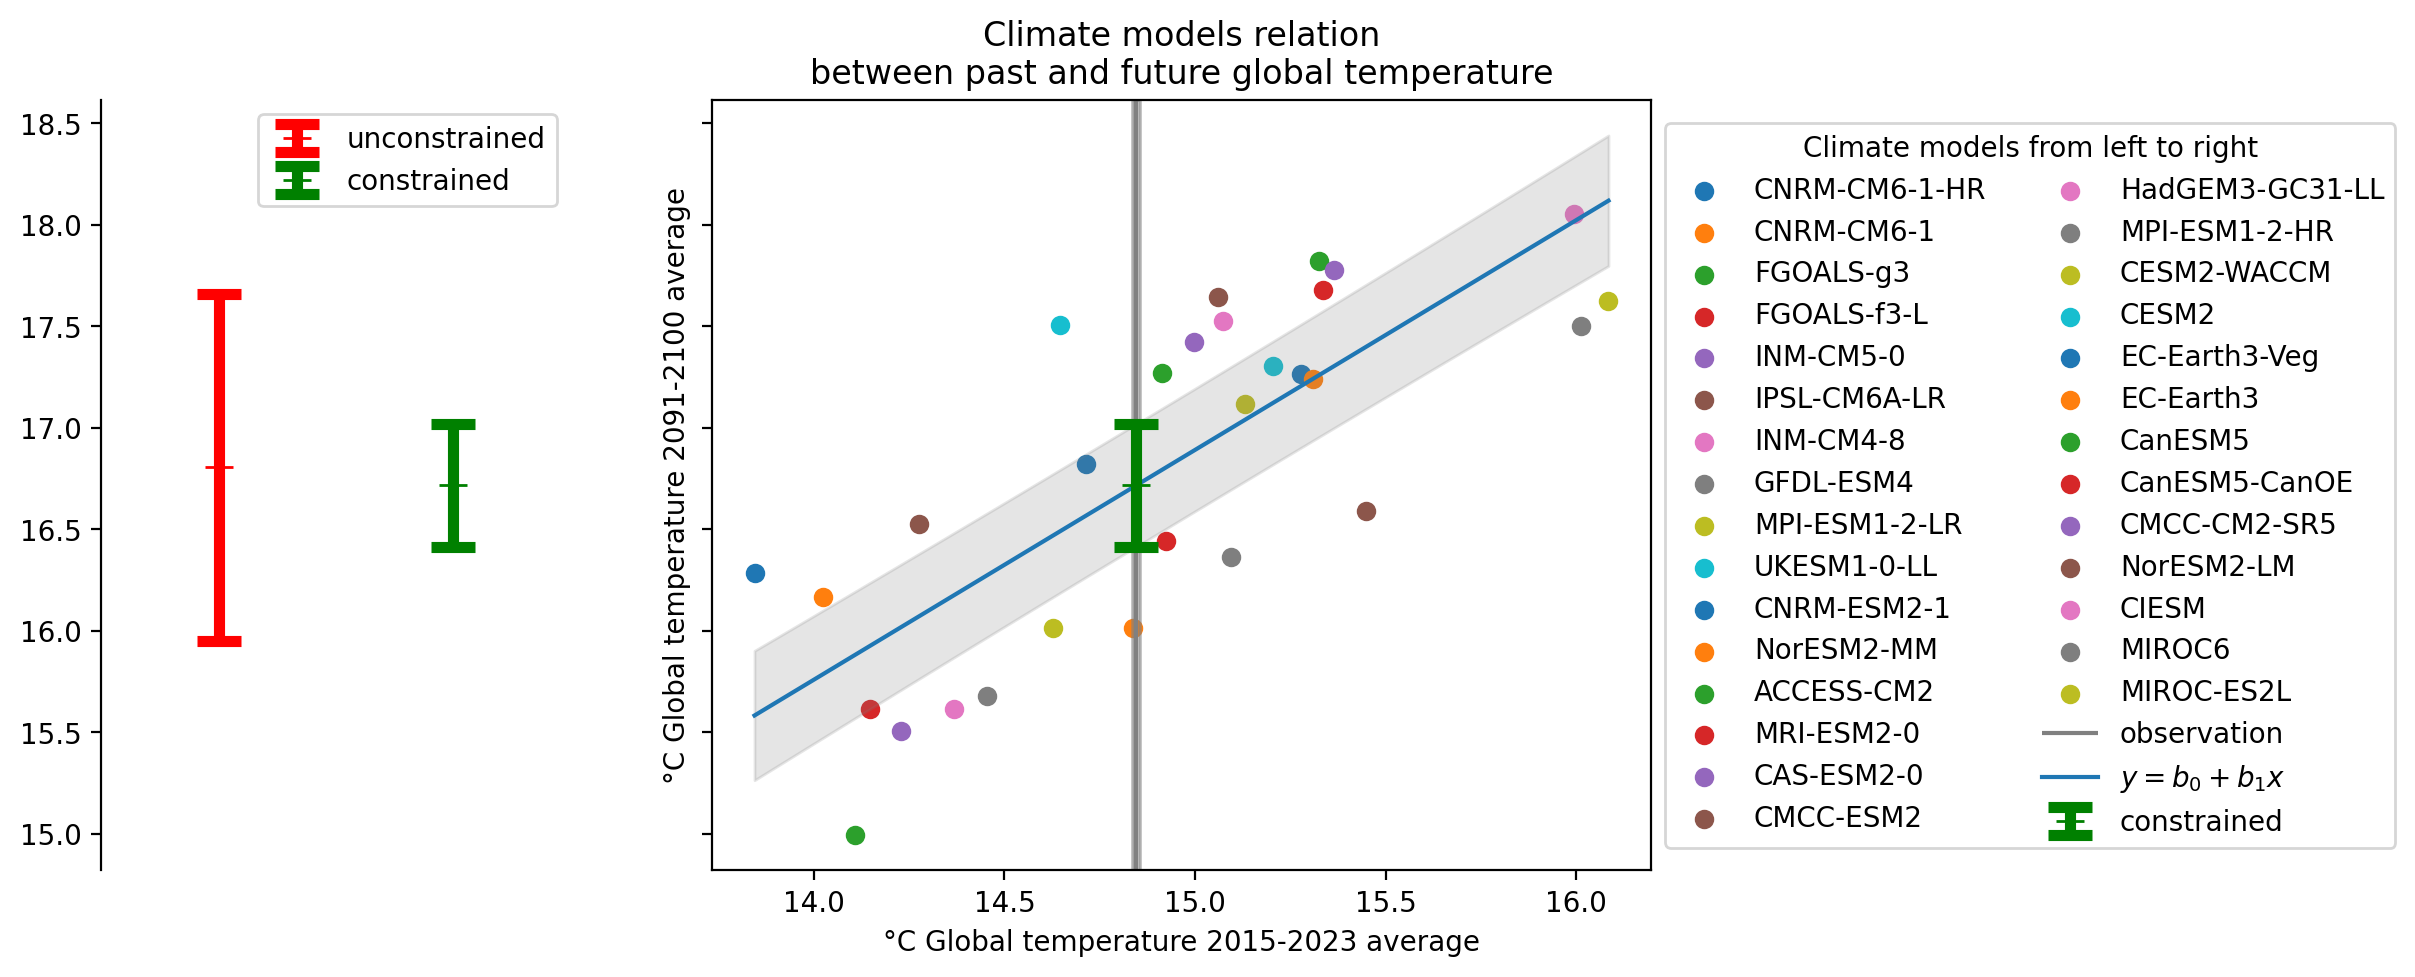

In [5]:
fig, axes = plt.subplots(1,2, figsize=(10,5), dpi=200, width_ratios=(0.5,1), sharey=True)

lw = 4
plot_interval(axes[0], 0, unconstrained_interval, "red", lw, w_bar=0.4, label="unconstrained")
plot_interval(axes[0], 1, constrained_interval, "green", lw, w_bar=0.4, label="constrained")
axes[0].set_xlim(-0.5,1.5)
axes[0].legend()
axes[0].spines['right'].set_visible(False)
axes[0].spines['top'].set_visible(False)
axes[0].spines['bottom'].set_visible(False)
axes[0].set_xticks([])
#axes[0].set_yticks([])    

# Display each climate model
for id_model in np.argsort(X_mod):
    axes[1].scatter(X_mod[id_model], Y_mod[id_model], label="{}".format(list_models[id_model]))
axes[1].set_xlabel("°C Global temperature {}-{} average".format(min_X, max_X))
axes[1].set_ylabel("°C Global temperature {}-{} average".format(min_Y, max_Y))

# Display the observation +- uncertainty
axes[1].fill_between(x, constrained_tube[:,0], constrained_tube[:,1], color="gray", alpha=0.2)
xmin, xmax = axes[1].get_xlim()
ymin, ymax = axes[1].get_ylim()
axes[1].vlines(X_obs, ymin, ymax, color='gray', label="observation")
axes[1].fill_betweenx([ymin, ymax], X_obs-std_obs, X_obs+std_obs, alpha=0.5, color='gray')
axes[1].plot(x, b0+b1*x, label=r"$y=b_0+b_1x$")
plot_interval(axes[1], X_obs, constrained_interval, "green", lw, w_bar=0.4, label="constrained")


# Editing
axes[1].set_xlim(xmin, xmax)
axes[1].set_ylim(ymin, ymax)
axes[1].legend(ncol=2, bbox_to_anchor=(1, 0.5), loc='center left', title="Climate models from left to right")
axes[1].set_title("Climate models relation\nbetween past and future global temperature")
plt.show()